## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import ceil
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

%matplotlib inline  

# Defining Paths

In [2]:
path = os.getcwd()
img_width, img_height = 224, 224

train_data_dir = os.path.join(path, r'..\Data\train')
val_data_dir = os.path.join(path, r'..\Data\validation')
test_data_dir = os.path.join(path, r'..\Data\test')

batch_size = 8

# Creating Data Generators

In [3]:
train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.2, 
                                   rotation_range=20, zoom_range=0.1, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
   train_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
   val_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
   test_data_dir,
   target_size=(img_height, img_width),
   batch_size=batch_size,
   class_mode='categorical')

Found 233 images belonging to 3 classes.
Found 55 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


# Load and compile pretrained Models

## Learning rate scheduler

In [4]:
##https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs

def lr_schedule(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [5]:
#create a Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)

## ResNET-50

In [6]:
model_res50 = applications.ResNet50(weights='imagenet', include_top=False) 
# add a global spatial average pooling layer
x = model_res50.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)
# add a dropout layer
x = Dropout(0.2)(x)

# and a fully connected output/classification layer
predictions = Dense(3, activation='softmax')(x)

# create the full network
model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [7]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [8]:
history_pretrained = model_transfer.fit(train_generator, epochs=epochs, shuffle = True, verbose = 1, validation_data = val_generator, callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
30/30 [==============================] - 78s 2s/step - loss: 1.1720 - accuracy: 0.4764 - recall: 0.4034 - precision: 0.4896 - val_loss: 1.3196 - val_accuracy: 0.3636 - val_recall: 0.3636 - val_precision: 0.3636 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009998999876494932.
Epoch 2/100
30/30 [==============================] - 71s 2s/step - loss: 0.6752 - accuracy: 0.7082 - recall: 0.6695 - precision: 0.7256 - val_loss: 1.1549 - val_accuracy: 0.3636 - val_recall: 0.2545 - val_precision: 0.3784 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009997000136010244.
Epoch 3/100
30/30 [==============================] - 72s 2s/step - loss: 0.5576 - accuracy: 0.7725 - recall: 0.7639 - precision: 0.8018 - val_loss: 1.5671 - val_accuracy: 0.3636 - val_recall: 0.3455 - val_precision: 0.3654 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate t

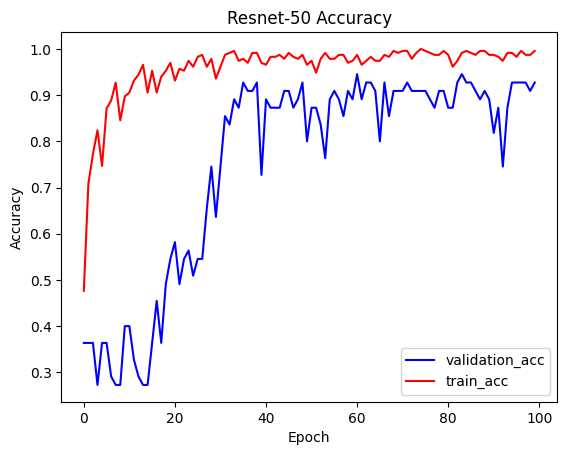

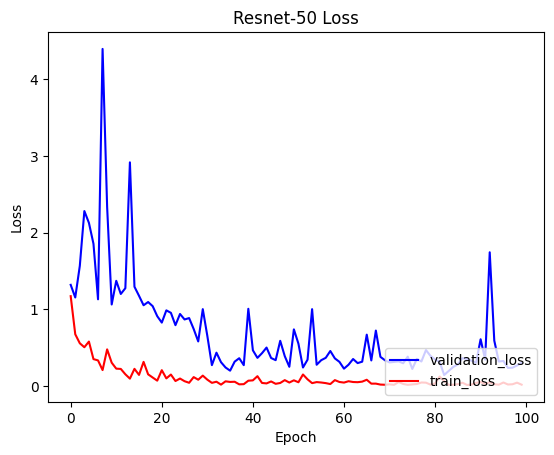

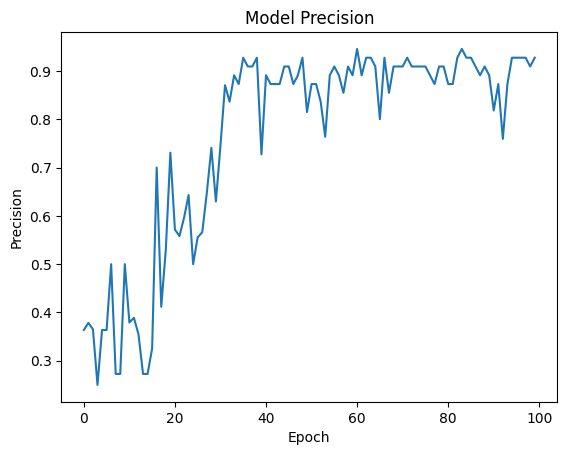

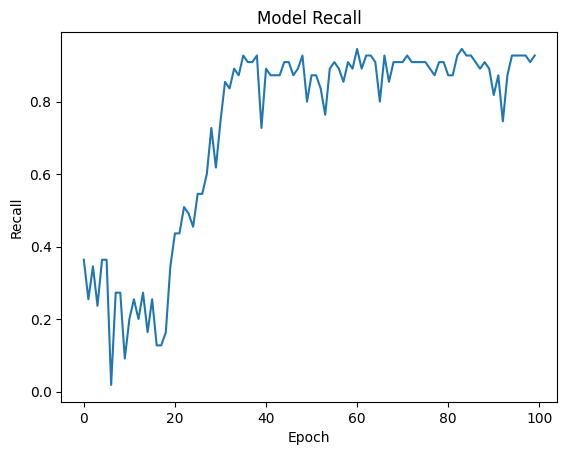

In [9]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'], "-b", label="validation_acc")
plt.plot(history_pretrained.history['accuracy'], "-r", label="train_acc")
plt.title('Resnet-50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'], "-b", label="validation_loss")
plt.plot(history_pretrained.history['loss'], "-r", label="train_loss")
plt.title('Resnet-50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# summarize history for precision
plt.plot(history_pretrained.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

# summarize history for recall
plt.plot(history_pretrained.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.show()

In [10]:
model_transfer.evaluate(test_generator)

4/4 [==============================] - 2s 415ms/step - loss: 0.8652 - accuracy: 0.7600 - recall: 0.7600 - precision: 0.7600


[0.8651637434959412,
 0.7599999904632568,
 0.7599999904632568,
 0.7599999904632568]

## VGG-16

In [11]:
model_vgg16 = applications.VGG16(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = model_vgg16.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)
# add a dropout layer
x = Dropout(0.2)(x)

# and a fully connected output/classification layer
predictions = Dense(3, activation='softmax')(x)

# create the full network
model_transfer_vgg = Model(inputs=model_vgg16.input, outputs=predictions)

In [12]:
# compile
model_transfer_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
history_pretrained_vgg = model_transfer_vgg.fit(train_generator, epochs=epochs, shuffle = True, verbose = 1, validation_data = val_generator, callbacks=[lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
30/30 [==============================] - 111s 4s/step - loss: 1.2085 - accuracy: 0.3176 - recall_1: 0.0858 - precision_1: 0.3636 - val_loss: 1.0986 - val_accuracy: 0.3636 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009998999876494932.
Epoch 2/100
30/30 [==============================] - 112s 4s/step - loss: 1.1073 - accuracy: 0.3648 - recall_1: 0.0172 - precision_1: 0.3077 - val_loss: 1.1016 - val_accuracy: 0.3636 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009997000136010244.
Epoch 3/100
 9/30 [========>.....................] - ETA: 1:16 - loss: 1.1019 - accuracy: 0.3611 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00

In [ ]:
# summarize history for accuracy
plt.plot(history_pretrained_vgg.history['val_accuracy'], "-b", label="validation_acc")
plt.plot(history_pretrained_vgg.history['accuracy'], "-r", label="train_acc")
plt.title('VGG-16 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# summarize history for loss
plt.plot(history_pretrained_vgg.history['val_loss'], "-b", label="validation_loss")
plt.plot(history_pretrained_vgg.history['loss'], "-r", label="train_loss")
plt.title('VGG-16 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

# summarize history for precision
plt.plot(history_pretrained_vgg.history['val_precision_1'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

# summarize history for recall
plt.plot(history_pretrained_vgg.history['val_recall_1'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model_transfer_vgg.evaluate(test_generator)

# Saving Model

In [ ]:
model_path = './../Trained_Model/model_resnet.h5'
model_transfer.save(model_path)

In [ ]:
model_path_vgg = './../Trained_Model/model_vgg.h5'
model_transfer_vgg.save(model_path_vgg)